In [2]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from src.gmm import GMM
import src.utils as utils

In [3]:
df = pd.read_csv("data/diamonds.csv")
X_train, X_test, y_train, y_test = utils.preprocessing_LOS(df)

First we search for the best `covariance_type` and `init_params` parameters, with a fixed `n_components` to 5.

In [17]:
param_grid = {
	"covariance_type": ["full", "tied", "diag", "spherical"],
	"init_params": ["kmeans", "random", "random_from_data"],
}

grid_search = GridSearchCV(GMM(n_components=5, max_iter=200, n_init=5), param_grid, cv=5, scoring="accuracy",
							   return_train_score=True, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=<src.gmm.GMM object at 0x00000176BAA4A610>,
             n_jobs=-1,
             param_grid={'covariance_type': ['full', 'tied', 'diag',
                                             'spherical'],
                         'init_params': ['kmeans', 'random',
                                         'random_from_data']},
             return_train_score=True, scoring='accuracy', verbose=10)

In [18]:
sorted(zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]), reverse=True, key=lambda x: x[0])

[(0.6723116844866422, {'covariance_type': 'full', 'init_params': 'random'}),
 (0.6653303361412778,
  {'covariance_type': 'full', 'init_params': 'random_from_data'}),
 (0.6571813864297379, {'covariance_type': 'full', 'init_params': 'kmeans'}),
 (0.6269205683625956, {'covariance_type': 'tied', 'init_params': 'kmeans'}),
 (0.6062696954958798, {'covariance_type': 'tied', 'init_params': 'random'}),
 (0.6045972806488928,
  {'covariance_type': 'tied', 'init_params': 'random_from_data'}),
 (0.5789825905794197,
  {'covariance_type': 'spherical', 'init_params': 'kmeans'}),
 (0.5788227736098894,
  {'covariance_type': 'spherical', 'init_params': 'random_from_data'}),
 (0.5728770489507509,
  {'covariance_type': 'spherical', 'init_params': 'random'}),
 (0.5305654296408813, {'covariance_type': 'diag', 'init_params': 'kmeans'}),
 (0.5212217121797245,
  {'covariance_type': 'diag', 'init_params': 'random_from_data'}),
 (0.5187532000474204, {'covariance_type': 'diag', 'init_params': 'random'})]

Once found the best values for these two parameters, we search for the best `n_components`.

In [20]:
param_grid = {
	"n_components": [1, 5, 10, 15, 20]
}

grid_search = GridSearchCV(GMM(covariance_type="full",max_iter=200, n_init=5, init_params="random"),
									param_grid, cv=5, scoring="accuracy",
									return_train_score=True, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=<src.gmm.GMM object at 0x00000176BAA7A0D0>,
             n_jobs=-1, param_grid={'n_components': [1, 5, 10, 15, 20]},
             return_train_score=True, scoring='accuracy', verbose=10)

In [21]:
sorted(zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]), reverse=True, key=lambda x: x[0])

[(0.7016165565913182, {'n_components': 15}),
 (0.6951130491121075, {'n_components': 10}),
 (0.6723116844866422, {'n_components': 5}),
 (0.6518456635162798, {'n_components': 20}),
 (0.6062696954958798, {'n_components': 1})]

The optimal value is between 10 and 15. As the difference is too small, we will take 10 that is less computationally expensive.

In [4]:
model = GMM(n_components=10, max_iter=200, n_init=5, covariance_type="full", init_params="random")
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.7008093405864402,
 'precision': 0.5703703703703704,
 'recall': 0.7298578199052133,
 'f1': 0.6403326403326404}

The model achieves a high recall but a low precision.

In [5]:
result_df = pd.DataFrame({"y_val": y_val, "y_pred": model.predict(X_val)})
result_counts = result_df.apply(pd.Series.value_counts)
result_counts

,y_val,y_pred
2,3243,2934
3,1884,1920
4,1731,1807
1,633,810
0,46,66


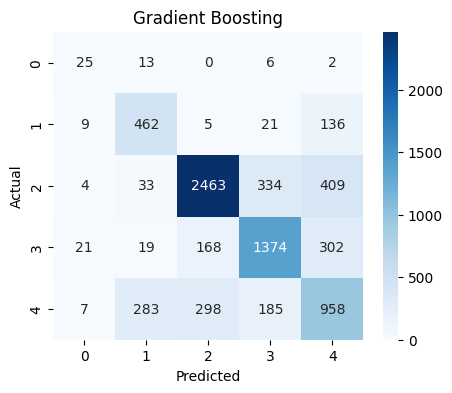

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = model.conf_matrix(X_val, y_val)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

We will try if using one-hot encoding results any better.

In [9]:
X_train, X_test, y_train, y_test = utils.preprocessing_HOS(df)
X_train.head()

,carat,depth,table,price,x,y,z,color_D,color_E,color_F,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-1.046007,0.912418,0.858806,-0.906311,-1.239264,-1.210759,-1.149612,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,-0.800225,1.453721,0.365250,-0.793411,-0.786307,-0.910304,-0.716824,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.920247,-1.523446,0.858806,1.514598,1.087287,1.130717,0.914454,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,-0.663680,0.822201,-0.621862,-0.756662,-0.652479,-0.630570,-0.567013,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,-0.964079,0.100463,0.365250,-0.883201,-1.064258,-1.034630,-1.033092,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
param_grid = {
	"covariance_type": ["full", "tied", "diag", "spherical"],
	"init_params": ["kmeans", "random", "random_from_data"],
}

grid_search = GridSearchCV(GMM(n_components=5, max_iter=200, n_init=5), param_grid, cv=5, scoring="accuracy",
							   return_train_score=True, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=<src.gmm.GMM object at 0x000001CF36E68DC0>,
             n_jobs=-1,
             param_grid={'covariance_type': ['full', 'tied', 'diag',
                                             'spherical'],
                         'init_params': ['kmeans', 'random',
                                         'random_from_data']},
             return_train_score=True, scoring='accuracy', verbose=10)

In [11]:
sorted(zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]), reverse=True, key=lambda x: x[0])

[(0.6129494493830435,
  {'covariance_type': 'spherical', 'init_params': 'random'}),
 (0.6101366591482023,
  {'covariance_type': 'spherical', 'init_params': 'kmeans'}),
 (0.6089956216001062,
  {'covariance_type': 'spherical', 'init_params': 'random_from_data'}),
 (0.5392596523815841, {'covariance_type': 'tied', 'init_params': 'random'}),
 (0.4894255008624121, {'covariance_type': 'tied', 'init_params': 'kmeans'}),
 (0.4242006103224094,
  {'covariance_type': 'full', 'init_params': 'random_from_data'}),
 (0.3992835345628234, {'covariance_type': 'full', 'init_params': 'kmeans'}),
 (0.3406660474990049, {'covariance_type': 'full', 'init_params': 'random'}),
 (0.2896377869178718,
  {'covariance_type': 'tied', 'init_params': 'random_from_data'}),
 (0.25198354783070187,
  {'covariance_type': 'diag', 'init_params': 'random_from_data'}),
 (0.24643757463181637, {'covariance_type': 'diag', 'init_params': 'kmeans'}),
 (0.20899562160010615, {'covariance_type': 'diag', 'init_params': 'random'})]

In [12]:
param_grid = {
	"n_components": [1, 5, 10, 15, 20]
}

grid_search = GridSearchCV(GMM(covariance_type="spherical",max_iter=200, n_init=5, init_params="random"),
							   param_grid, cv=5, scoring="accuracy",
							   return_train_score=True, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=<src.gmm.GMM object at 0x000001CF56C9A550>,
             n_jobs=-1, param_grid={'n_components': [1, 5, 10, 15, 20]},
             return_train_score=True, scoring='accuracy', verbose=10)

In [13]:
sorted(zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]), reverse=True, key=lambda x: x[0])

[(0.620246782539472, {'n_components': 15}),
 (0.6195833886161604, {'n_components': 10}),
 (0.6195037813453629, {'n_components': 20}),
 (0.6129494493830435, {'n_components': 5}),
 (0.46002388218123924, {'n_components': 1})]

In [14]:
model = GMM(n_components=15, max_iter=200, n_init=5, covariance_type="spherical", init_params="random")
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.6182831365264694,
 'precision': 0.41453428863868985,
 'recall': 0.6398104265402843,
 'f1': 0.5031055900621118}

One-hot encoding didn't give better results. As an observation, the recall is much higher than the precision, similarly to label encoding.

Thus, we will stay with label encoding as preprocessing. The best parameters have been selected, so we proceed to test the model.

In [15]:
X_train, X_test, y_train, y_test = utils.preprocessing_LOS(df)
model = GMM(n_components=10, max_iter=200, n_init=5, covariance_type="full", init_params="random")
model.fit(X_train, y_train)
model.compute_metrics(X_test, y_test)

{'accuracy': 0.6873275313097007,
 'precision': 0.5516129032258065,
 'recall': 0.726628895184136,
 'f1': 0.6271393643031785}

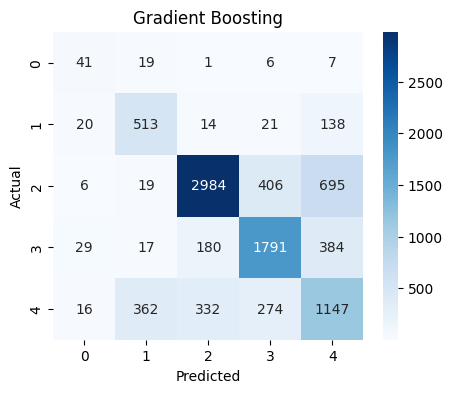

In [16]:
conf_mat = model.conf_matrix(X_test, y_test)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()